In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
from scipy.optimize import linear_sum_assignment

# plt.rcparams222['image.cmap'] = 'gray'

show_all = True

In [5]:
def well_plate(id):
    
    position = [197.5, 192.5]
    well_offset = 13.55
    
    if id[0] == 'A':
        position[0] = position[0]
        position[1] = position[1] - int(id[1])*well_offset
    elif id[0] == 'B':
        position[0] = position[0] - 1*well_offset
        position[1] = position[1] - int(id[1])*well_offset
    elif id[0] == 'C':
        position[0] = position[0] - 3*well_offset
        position[1] = position[1] - int(id[1])*well_offset
    elif id[0] == 'D':
        position[0] = position[0] - 4*well_offset
        position[1] = position[1] - int(id[1])*well_offset
    elif id[0] == 'E':
        position[0] = position[0] - 5*well_offset
        position[1] = position[1] - int(id[1])*well_offset
    elif id[0] == 'F':
        position[0] = position[0] - 6*well_offset
        position[1] = position[1] - int(id[1])*well_offset
        
    return position
        
        

SyntaxError: incomplete input (1163341389.py, line 6)

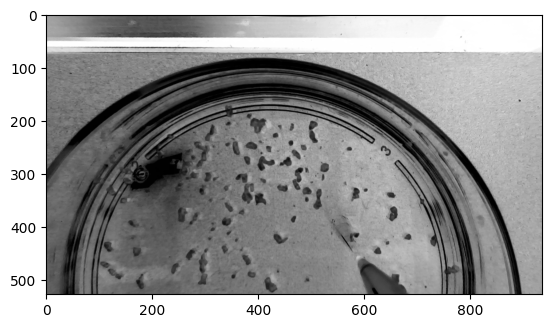

In [432]:
number_before = 0
number_after = 20
images_before = []
images_before_gray = []
images_after = []
images_after_gray = []

for i in range(5):
    images_before.append(cv2.cvtColor(cv2.imread(r'C:\Users\APrap\Documents\CREATE\Pick-and-Place\Pictures\detection/image_check' + str(number_before+i)+'.png'), cv2.COLOR_BGR2RGB))
    images_before_gray.append(255 - cv2.cvtColor(cv2.imread(r'C:\Users\APrap\Documents\CREATE\Pick-and-Place\Pictures\detection/image_check' + str(number_before+i)+'.png'), cv2.COLOR_BGR2GRAY))
    images_after.append(cv2.cvtColor(cv2.imread(r'C:\Users\APrap\Documents\CREATE\Pick-and-Place\Pictures\detection/image_check' + str(number_after+i)+'.png'), cv2.COLOR_BGR2RGB))
    images_after_gray.append(255 - cv2.cvtColor(cv2.imread(r'C:\Users\APrap\Documents\CREATE\Pick-and-Place\Pictures\detection/image_check' + str(number_after+i)+'.png'), cv2.COLOR_BGR2GRAY))

if show_all:
    plt.imshow(images_after_gray[0], cmap='gray')

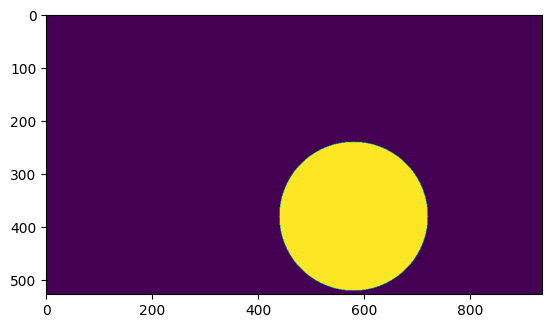

In [433]:
mask = np.zeros(images_before_gray[0].shape[0:2], dtype='uint8')

center_coordinates = (580, 380)
radius = 140
color = 255
thickness = -1

mask = cv2.circle(mask, center_coordinates, radius, color, thickness)
            
if show_all:
    plt.imshow(mask)

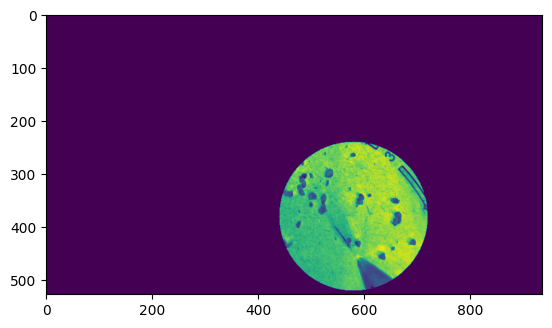

In [434]:
zoi = cv2.bitwise_and(images_before_gray[4], images_before_gray[4], mask=mask)
if show_all:
    plt.imshow(zoi)

In [435]:
class Sample:
    def __init__(self, x, y, size):
        self.x = x
        self.y = y
        self.size = size
        self.linked = False
        self.matched = False
        self.certainty = 0
        
    def link(self, sample):
        sample.linked = True
        self.certainty += 1
        
        self.x = (self.x + sample.x)/2
        self.y = (self.y + sample.y)/2
        self.size = (self.size + sample.size)/2
        
    def match_with(self, sample, max_size_dif, max_position_dif):
        if np.sqrt((self.x-sample.x)**2+(self.y-sample.y)**2) < max_position_dif and np.abs(self.size-sample.size) < max_size_dif:
            self.matched = True
            sample.matched = True
        

In [436]:
# def cost(sample1, sample2):
#     """Compute the cost function between the two samples."""
#     dist = math.sqrt((sample1.x-sample2.x)**2 + (sample1.y-sample2.y)**2)
#     d_size = math.abs(sample1.size - sample2.size)
#     return dist + 5*d_size

# def update_samples(samples, new_samples):
#     """Find the best combination of pairs to link all points in points1 to all points in points2."""
#     n = len(samples)
#     m = len(new_samples)
#     cost = np.zeros((n, m))
#     for i in range(n):
#         for j in range(m):
#             cost[i, j] = cost(samples[i], new_samples[j])
#     row_ind, col_ind = linear_sum_assignment(cost)
#     for i, j in zip(row_ind, col_ind):
#         samples[i].link(new_samples[j])
#     for sample in new_samples:
#         if not sample.linked:
#             samples.append(sample)
#     return samples

In [494]:
def create_intruder_detector_near():
    
    params = cv2.SimpleBlobDetector_Params()

    # Change thresholds
    params.minThreshold = 30
    params.maxThreshold = 240


    # Filter by Area.
    params.filterByArea = True
    params.minArea = 45
    params.maxArea = 1000

    # Filter by Circularity
    params.filterByCircularity = True
    params.minCircularity = 0.4

    # Filter by Convexity
    params.filterByConvexity = False
    params.minConvexity = 0.8

    # Filter by Inertia
    params.filterByInertia = True
    params.minInertiaRatio = 0.1
    
    # Create a detector with the parameters
    # OLD: detector = cv2.SimpleBlobDetector(params)
    detector = cv2.SimpleBlobDetector_create(params)
    
    return detector

In [495]:
YELLOW = (255, 255, 0)
GREEN = (0, 255, 0)
RED = (255, 0, 0)
BLUE = (0, 0, 255)

def d_circle(img, keypoints, radius, color):
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 0.5
    thickness = 1

    for i in range(len(keypoints)):
            img = cv2.circle(img, (int(keypoints[i].pt[0]),int(keypoints[i].pt[1])), int(keypoints[i].size), color, thickness)      
    
    return img

def d_samples(img, samples, color):
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 0.5
    thickness = 1
    

    for sample in samples:
        img = cv2.circle(img, (int(sample.x),int(sample.y)), int(sample.size), color, thickness)   
        size, _ = cv2.getTextSize(str(sample.certainty), font, fontScale, thickness)
        img = cv2.putText(img, str(sample.certainty), (int(sample.x-size[0]/2),int(sample.y-5)), font, 
                    fontScale, color, thickness, cv2.LINE_AA)
    
    return img

In [496]:
def cost_fct(sample1, sample2):
    """Compute the cost function between the two samples."""
    dist = math.sqrt((sample1.x-sample2.x)**2 + (sample1.y-sample2.y)**2)
    d_size = np.abs(sample1.size - sample2.size)
    return dist + 0*d_size

def update_samples(samples, new_samples):
    """Find the best combination of pairs to link all points in points1 to all points in points2."""
    n = len(samples)
    m = len(new_samples)
    
    for i in range(n):
        min_cost = None
        id = 0
        for j in range(m):
            actual_cost = cost_fct(samples[i], new_samples[j])
            if min_cost is None or actual_cost < min_cost:
                min_cost = actual_cost
                id = j
        if np.abs(samples[i].size - new_samples[id].size) < 20:
            samples[i].link(new_samples[id])
            
    for sample in new_samples:
        if not sample.linked:
            samples.append(sample)
            
    return samples

In [497]:
def update_samples_opti(samples, new_samples):
    """Find the best combination of pairs to link all points in points1 to all points in points2."""
    n = len(samples)
    m = len(new_samples)
    
    cost = np.zeros((n, m))
    
    for i in range(n):
        for j in range(m):
            cost[i, j] = cost_fct(samples[i], new_samples[j])
    
    row_ind, col_ind = linear_sum_assignment(cost)
            
    for i, j in zip(row_ind, col_ind):
            samples[i].link(new_samples[j])
            
    return samples

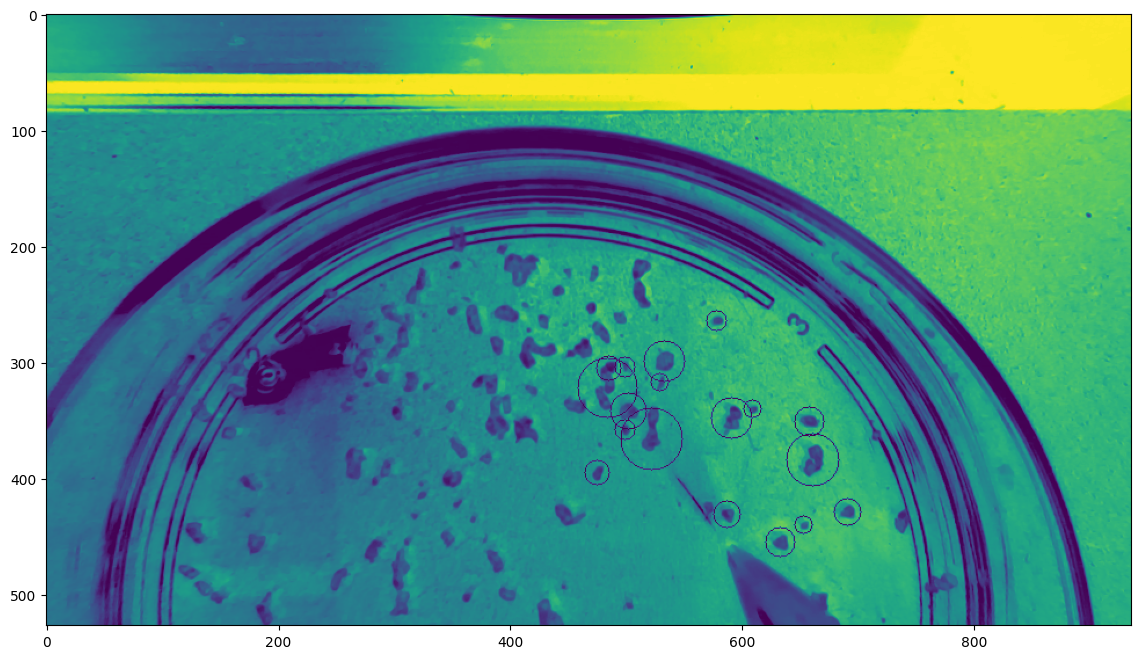

In [498]:
out = zoi.copy()
out2 = images_before_gray[0].copy()
intruder_detector = create_intruder_detector_near()

keypoints = intruder_detector.detect(out)

out = d_circle(out2, keypoints, 15, BLUE)
          
plt.figure(figsize=(14,10))
plt.imshow(out)

In [499]:
def detect_sample(images, detector, mask, min_certainty):
    """Create samples and update them with the other images"""
    zoi = cv2.bitwise_and(images[0], images[0], mask=mask)
    keypoints = detector.detect(zoi)
    samples = []
    for keypoint in keypoints:
        samples.append(Sample(keypoint.pt[0], keypoint.pt[1], keypoint.size))
        
    for image in images[1:]:
        zoi = cv2.bitwise_and(image, image, mask=mask)
        keypoints = detector.detect(zoi)
        new_samples = []
        for keypoint in keypoints:
            new_samples.append(Sample(keypoint.pt[0], keypoint.pt[1], keypoint.size))
            
        # samples = update_samples(samples, new_samples)
        samples = update_samples_opti(samples, new_samples)
    
    id = 0
    while id < len(samples):
        if samples[id].certainty < min_certainty:
            del samples[id]
        else:
            id += 1
        
    return samples

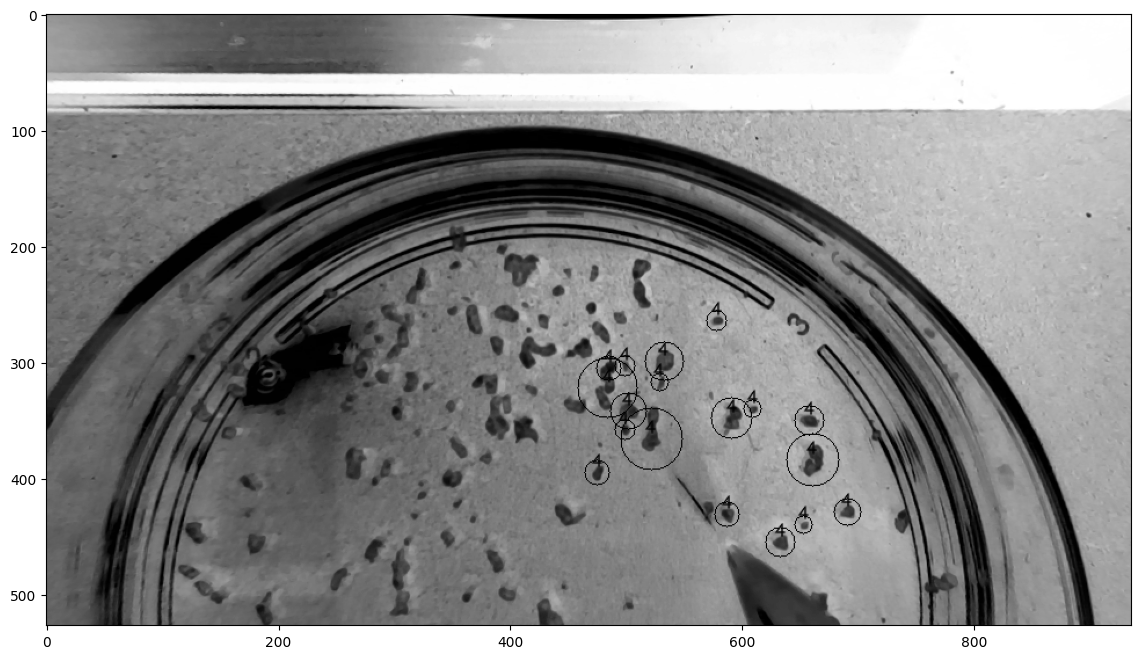

In [500]:
images = images_before_gray

out = images[0].copy()

intruder_detector = create_intruder_detector_near()

samples_before = detect_sample(images, intruder_detector, mask, 3)

out = d_samples(out, samples_before, BLUE)

plt.figure(figsize=(14,10))
plt.imshow(out, cmap='gray')

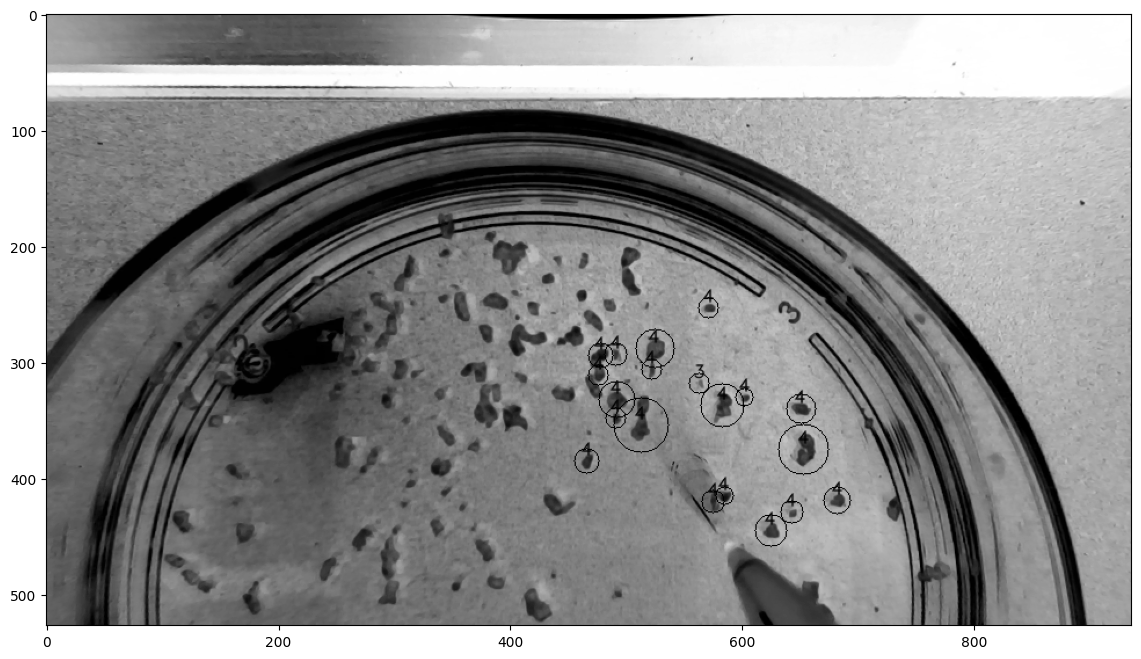

In [501]:
images = images_after_gray

out = images[0].copy()

intruder_detector = create_intruder_detector_near()

samples_after = detect_sample(images, intruder_detector, mask, 3)

out = d_samples(out, samples_after, BLUE)

plt.figure(figsize=(14,10))
plt.imshow(out, cmap='gray')

In [502]:
def detect_pickup(samples_before, samples_after):
    
                
    center_coordinates = (580, 380)
    radius = 90   
    max_cost_threshold = 50
    max_size_threshold = 20
    
    # Remover matching samples 
    i = 0
    while i < len(samples_before):
        j = 0
        min_cost = None
        id = 0
        while j < len(samples_after):
            actual_cost = cost_fct(samples_before[i], samples_after[j])
            if min_cost is None or actual_cost < min_cost:
                min_cost = actual_cost
                id = j
            j += 1
        if min_cost < max_cost_threshold and np.abs(samples_before[i].size - samples_after[id].size) < max_size_threshold:
            del samples_before[i]
            del samples_after[id]
        else:
            print(min_cost, np.abs(samples_before[i].size - samples_after[id].size))
            i += 1
            
    # Remove non matching samples far from center
    i = 0
    while i < len(samples_before):
        if np.sqrt((samples_before[i].x - center_coordinates[0])**2+(samples_before[i].y - center_coordinates[1])**2) > radius:
            del samples_before[i]
        else:
            i += 1
    i = 0
    while i < len(samples_after):
        if np.sqrt((samples_after[i].x - center_coordinates[0])**2+(samples_after[i].y - center_coordinates[1])**2) > radius:
            del samples_after[i]
        else:
            i += 1
            
            
    out = images_before_gray[0].copy()
    out = d_samples(out, samples_after, BLUE)
    out = d_samples(out, samples_before, BLUE)

    plt.figure(figsize=(14,10))
    plt.imshow(out, cmap='gray')
            
    # Only one left => Success else fail
    if len(samples_after) == 0 and len(samples_before) == 1:
        return True
    elif len(samples_after) == 0 and len(samples_before) == 0:
        print('No missing sample')
    elif len(samples_after) == 1 and len(samples_before) == 2:
        print('Two unmatch samples, maybe due to aglomeration')
    else:
        print('Remaining samples : ', len(samples_after), 'Samples before : ', len(samples_before))
        return False

In [503]:
def detect_pickup_opti(samples_before, samples_after):
    
                
    center_coordinates = (580, 380)
    radius = 70   
    max_dist_threshold = 50
    max_size_threshold = 20
    
    # Remover matching samples 
    n = len(samples_before)
    m = len(samples_after)
    cost = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            cost[i, j] = cost_fct(samples_before[i], samples_after[j])
    
    row_ind, col_ind = linear_sum_assignment(cost)
    for i, j in zip(row_ind, col_ind):
            samples_before[i].match_with(samples_after[j], max_dist_threshold, max_size_threshold)
    i = 0
    while i < len(samples_before):
        if samples_before[i].matched:
            del samples_before[i]
        else:
            i += 1
    i = 0
    while i < len(samples_after):
        if samples_after[i].matched:
            del samples_after[i]
        else:
            i += 1
            
    # Remove non matching samples far from center
    i = 0
    while i < len(samples_before):
        if np.sqrt((samples_before[i].x - center_coordinates[0])**2+(samples_before[i].y - center_coordinates[1])**2) > radius:
            del samples_before[i]
        else:
            i += 1
    i = 0
    while i < len(samples_after):
        if np.sqrt((samples_after[i].x - center_coordinates[0])**2+(samples_after[i].y - center_coordinates[1])**2) > radius:
            del samples_after[i]
        else:
            i += 1
            
            
    out = images_before_gray[0].copy()
    out = d_samples(out, samples_after, BLUE)
    out = d_samples(out, samples_before, BLUE)

    plt.figure(figsize=(14,10))
    plt.imshow(out, cmap='gray')
            
    # Only one left => Success else fail
    if len(samples_after) == 0 and len(samples_before) == 1:
        return True
    elif len(samples_after) == 0 and len(samples_before) == 0:
        print('No missing sample')
    elif len(samples_after) == 1 and len(samples_before) == 2:
        print('Two unmatch samples, maybe due to aglomeration')
    else:
        print('Samples before : ', len(samples_before), ' Remaining samples : ', len(samples_after))
        return False

Samples before :  0  Remaining samples :  2
Fail


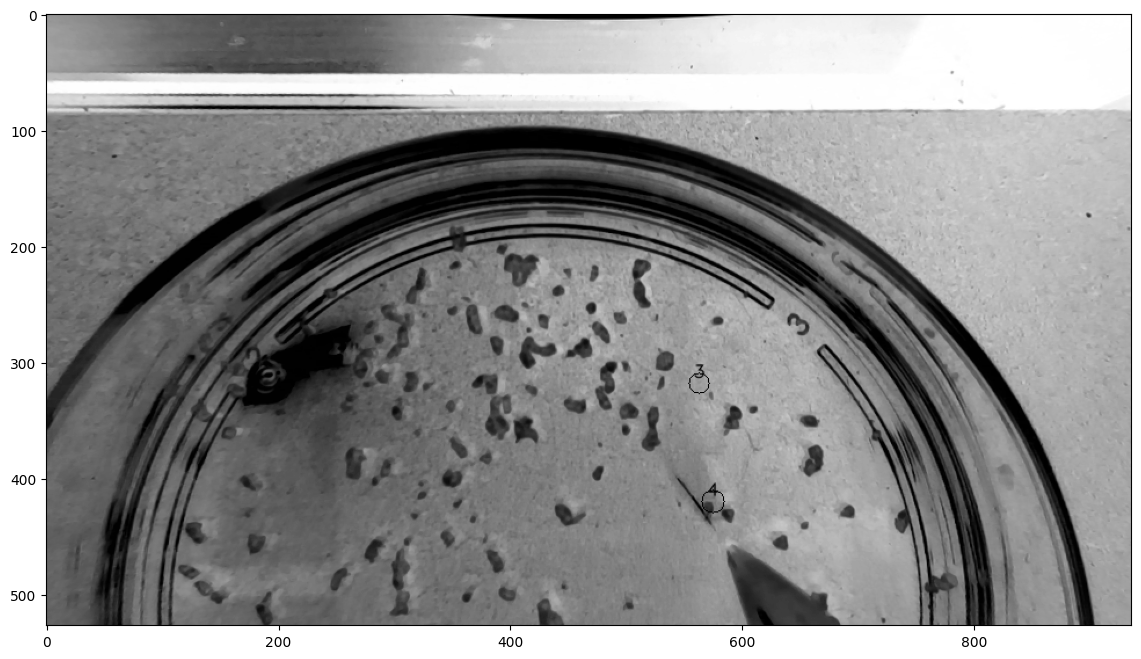

In [504]:
if detect_pickup_opti(samples_before, samples_after):
    print('Success')
else:
    print('Fail')